We can use a kd tree to find the edges of a surface. 

What we can do is draw random points inside a cube and check whether two of them are on different sides of surface of the volume. 

In [1]:
import numpy as np

import matplotlib
#matplotlib.use('WebAgg')
#matplotlib.use('Qt4Cairo')
#matplotlib.use('Qt5Cairo')
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
class Cube:
    def __init__(self,center,distance):
        self.center=center
        self.distance=distance
        self.dim=len(center)

#         self.generate_signs()#this list will hep us move a point towards backwards and forward directions in all axes 
        self.vertex_points()

    def sign(self,i,j):
        '''
        If you imagine a circle divided into j equal picies with \delta\theta=\pi/(2^(j-1)), 
        then the sign can be defined as + if \theta = i*\delta\theta <= \pi and - if \theta = i*\delta\theta > \pi.
        '''
        #shift to call i,j as a list that start from 0 at 0
        i=i+1
        j=j+1
        
        dt=1/2**(j-1)#the step in units of \pi
        t=(i-1)#the steps you take, i=\theta/\delta\theta

        semicircle=np.floor((t*dt)%2)#this checks whether you are in the upper or lower half of the circle
        return int((-1)**semicircle)#this gives you the sign

    def generate_signs(self):
        '''
        The code below generates a list of signs that will move a point to all posible directions.
        Example for 2 dimensions this will give us
        
        [
            [1,1],
            [1,-1],
            [-1,1],
            [-1,-1]
        ]
        
        In three dimensions  
        [
            [1, 1, 1],
            [1, 1, -1],
            [1, -1, 1],
            [1, -1, -1],
            [-1, 1, 1],
            [-1, 1, -1],
            [-1, -1, 1],
            [-1, -1, -1]
        ]
        
        I came up with this code by trying different things and simplifying the result.
        
        What you need to do to replicate it is to draw on a board what you wat to do:
        take all possible combinations od size=self.dim of a list of +1 and -1 (there are dim**2 combinations).
        What you need to do is understand how to do this:
        
        + +
        + -
        - +
        - -
        
        Then this
        + + +
        + + -
        + - +
        + - -
        - + +
        - + -
        - - +
        - - -
        
        Then the pattern emerges: the last one changes every 1 step the second to last every 2, third to last every 4. 
        Translate this into a for-loop, and you have your result :)
        '''
        self.signs=[[0 for __ in range(self.dim)] for _ in range(2**self.dim)]
        for j in range(self.dim):
            count=0
            for i in range(2**self.dim):
                self.signs[i][j]=(-1)**count
                if (i+1)%(2**(self.dim-1-j))==0:
                    count+=1
                    if count==2:
                        count=0 

    def check_point(self,point):
        '''check whether point is inside this square'''
        for i in range(self.dim):
            if point[i]>self.center[i]+self.distance or point[i]<self.center[i]-self.distance:
                return False
        
        return True
    
    def vertex_points(self):
        '''generate all vertex points of the cube'''
        
        self.vertices=[]
        for bound in range(2**self.dim):
            self.vertices.append([self.center[d]+self.distance*self.sign(bound,d) for d in range(self.dim)])

            
    def random_point(self):
        '''generate a random point in this cube'''
        
        point=[]
        
        for d in range(self.dim):
            _M=self.center[d]+self.distance
            _m=self.center[d]-self.distance
            point.append(np.random.rand()*(_M-_m)+_m)
            
        return point

In [3]:
class DTree:
    '''
    The DTree class recursively subdivides the space.
    '''
    def __init__(self,boundary,max_depth=5,depth=0,default_depth=0):
        '''
        boundary: an instance of Cube. It is the cube that defines this "node" of the tree.
        
        max_depth: number of allowed subdivisions
        
        depth: depth of current node
        
        default_depth: number of subdivisions to perform when initiated. 
            You may want to start with a cube that is already subdivided...
        '''
        
        #We deal with cubes, but use the dim when you can. It will be easier to generalize later.
        self.dim=boundary.dim
        
        self.boundary=boundary
        self.max_depth=max_depth
        self.depth=depth
        
        #List of intances of DTree. This will hold the potential cubes.
        #Each instance of DTree has either 0 or dim**2 children.
        self.children=[0 for i in range(2**self.dim)]  
        self.has_children=False
        
        self.checked=False
        
        for i in range(default_depth):
            self.subdivide_all()
        
                        
    def subdivide(self):
        '''Subdivide the current cube'''
        self.has_children=True
        new_distance = self.boundary.distance/2. #the distance of all new cubes
        for i in range(2**self.dim):
            new_center = [ self.boundary.sign(i,d)*new_distance + self.boundary.center[d] for d in range(self.dim)]
            child = Cube( new_center , new_distance )
            self.children[i]=DTree(child,self.max_depth,self.depth+1)
        
    def subdivide_all(self):
        '''Subdivide all smallest cubes'''
        if self.depth==self.max_depth:
            return
        
        if self.has_children:
            for _ in self.children:
                _.subdivide_all()
        else:
            self.subdivide()
            return
        
    def check(self,condition):
        '''If condition is True, then subdivide, else do not.'''
        if condition and self.depth<self.max_depth:
            self.subdivide()
        return condition and self.depth<self.max_depth
            
    def mark(self):
        '''Mark this cude as checked'''
        self.checked=True
        
    def sample(self, number_of_points):
        '''draw a number of points in each cube'''
        points=[]
        if self.has_children:
            for child in self.children:
                for p in child.sample(number_of_points):
                    points.append(p)
        else:
            return [self.boundary.random_point() for _ in range(number_of_points)]
        return points
    
    
    def get_cubes(self):
        '''Get the cubes of the tree and its children  recursively'''
        cubes=[self.boundary]
        if self.has_children:
            for i in self.children:
                for c in i.get_cubes():
                    cubes.append(c)
        return cubes
    
    def get_nodes(self):
        '''Get all the subtrees'''
        nodes=[self]
        if self.has_children:
            for i in self.children:
                for c in i.get_nodes():
                    nodes.append(c)
        return nodes
    
    
    def get_last_nodes(self):
        '''Get the tree nodes at the lowest depth'''
        
        if self.has_children:
            nodes=[]
            for i in self.children:
                for c in i.get_last_nodes():
                    if c.has_children:
                        continue
                    nodes.append(c)
        else:        
            nodes=[self]

        return nodes
    
    
    def get_node(self,depth):
        '''Get the trees at given depth of each branch'''
        
        if self.depth==depth:
            return [self]
        else:
            if self.has_children:
                nodes=[]
                for ch in self.children:
                    for _ in ch.get_node(depth):
                        nodes.append(_)
            else:
                return []
        return nodes

In [4]:

def find_edge(function,Tree,number_of_points):
    '''
    Draw a number of random points to see if there is an edge in the current cube
    function: a function that defines a closed surface. 
                It should be defined as f(x)=0 on the surface. Example: x[0]**2+x[1]**2-1 defines the unit circle.
    Tree: the DTree to be subdivided in order to identify the edges.
    number_of_points: random number of points to draw in each cube in order to find the edge.
    '''
    if Tree.has_children:
        for child in Tree.children:
            find_edge(function,child,number_of_points)
    else:
        if Tree.checked:
            return
        else:
            Tree.mark()
            point_1=Tree.boundary.random_point()           
            
            if Tree.check( function(point_1)==0 ):
                return
            
            check_1=function(point_1)>0
            

            for i in range(number_of_points-1):
                point_2=Tree.boundary.random_point()
                check_2=function(point_2)>0
                if Tree.check( check_2 ^ check_1 ):
                    return
                
            #it is good to check the edges 
            for point_2 in Tree.boundary.vertices:
                if Tree.check( function(point_2)==0 ):
                    return
                


In [5]:
def f(x):
    return (x[0]-x[1])**2+(x[1]-0.5)**2-0.1

In [6]:
Qt=DTree(Cube([0.5,0.5],0.5),max_depth=15,depth=0,default_depth=2)

In [7]:
for _ in range(7):
    find_edge(f,Qt,500)

<IPython.core.display.Javascript object>


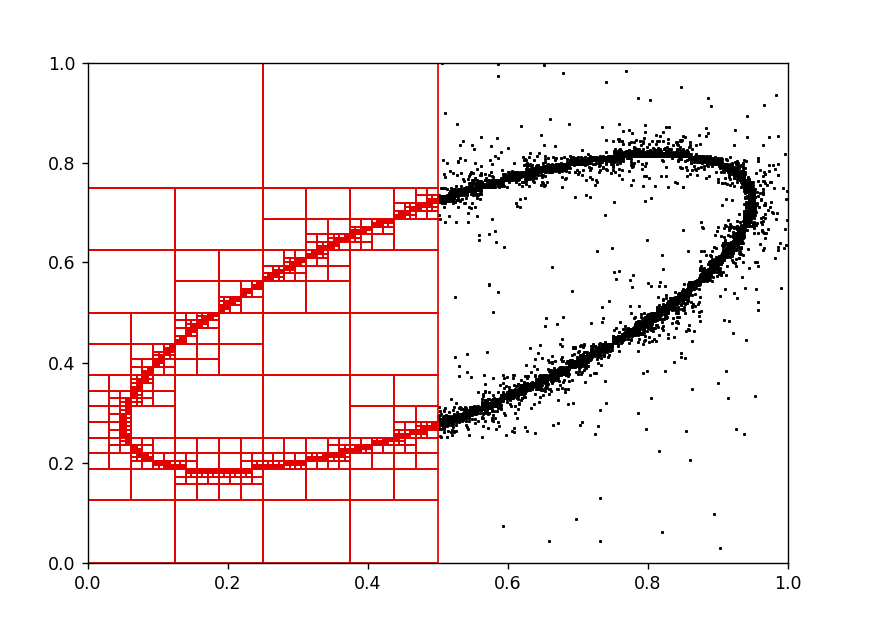

In [8]:
fig=plt.figure(figsize=(7,5))
fig.subplots_adjust(bottom=0.1, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.5)




sub = fig.add_subplot(111)

pp=np.array(Qt.sample(5))
points = []
for p in pp:
    if p[0]>0.5:
        points.append(p)
points=np.array(points)
sub.scatter(points[:,0],points[:,1],s=2,marker='+',color='xkcd:black')

nodes=np.array(Qt.get_last_nodes())

# cc=[]
# for _ in nodes:
#     cc.append(_.boundary.center)
# cc=np.array(cc)
# sub.scatter(cc[:,0][cc[:,0]>0.5],cc[:,1][cc[:,0]>0.5],s=2,marker='+',color='xkcd:black')



for _ in nodes:
    if _.boundary.center[0]<=0.5:
        pass
        sub.add_patch(
            Rectangle((_.boundary.center[0]-_.boundary.distance,_.boundary.center[1]-_.boundary.distance), _.boundary.distance*2, _.boundary.distance*2,
            facecolor='none',edgecolor='xkcd:red'),
        )




sub.set_xlim(0,1)
sub.set_ylim(0,1) 
plt.show()

In [9]:
def f(x):
#     return (x[0]-0.5)**2+(x[1]-0.5)**2+(x[2]-0.5)**2-0.1
    return (0.3-np.sqrt((x[0]-0.5)**2+(x[1]-0.5)**2))**2+(x[2]-0.5)**2-0.03



In [10]:
Qt=DTree(Cube([0.5,0.5,0.5],0.5),max_depth=7,depth=0,default_depth=0)

In [11]:
for _ in range(5):
    find_edge(f,Qt,300)

In [12]:
len(Qt.get_last_nodes())

6105

<IPython.core.display.Javascript object>


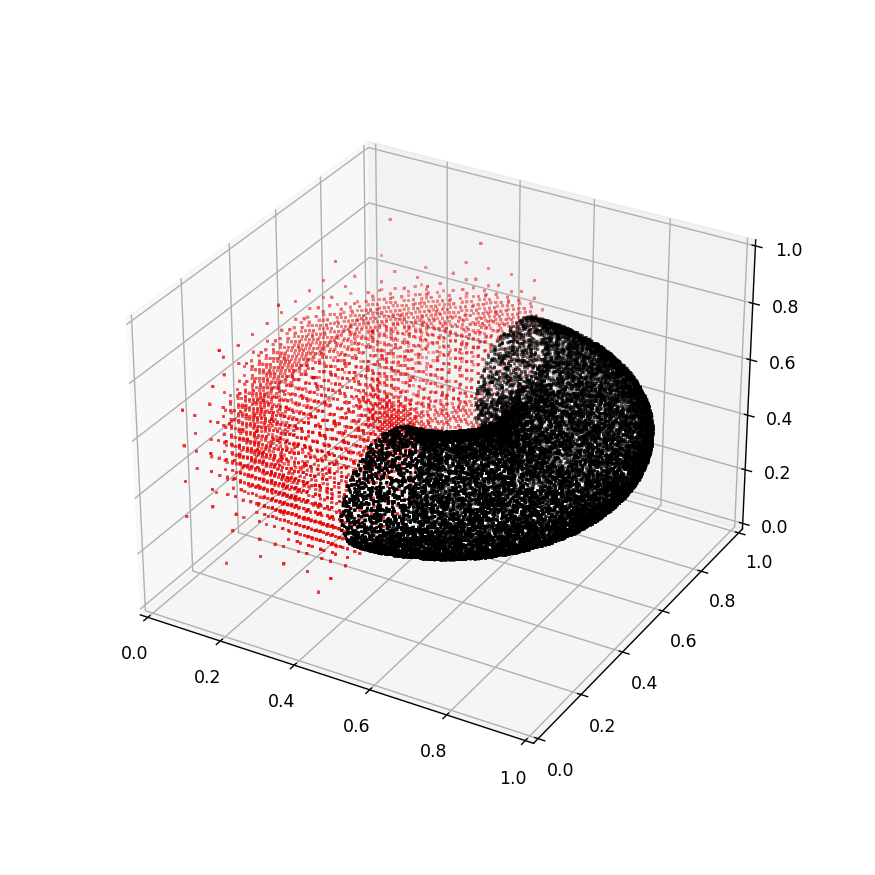

In [13]:
fig=plt.figure(figsize=(7,7))
fig.subplots_adjust(bottom=0.1, left=0.1, top = 0.9, right=0.9,wspace=0.0,hspace=0.5)




sub = fig.add_subplot(111,projection='3d')

nodes=np.array(Qt.get_last_nodes())
cc1=[]
cc2=[]
for _ in nodes:
    p=_.boundary.center
    if  p[0]<=0.5:
        cc1.append(p)
    else:
        if np.abs(f(p))<1e-2 and False:
            cc2.append(p)
        
cc1=np.array(cc1)
sub.scatter(cc1[:,0],cc1[:,1],cc1[:,2],s=2,marker='+',color='xkcd:red')

if len(cc2)>0:
    cc2=np.array(cc2)
    sub.scatter(cc2[:,0],cc2[:,1],cc2[:,2],s=2,marker='+',color='xkcd:black')


pp=np.array(Qt.sample(100))
points=[]
for p in pp:
    if np.abs(f(p))<1e-3 and p[0]>0.5:
        points.append(p)
        
if len(points)>0:
    points=np.array(points)
    sub.scatter(points[:,0],points[:,1],points[:,2],s=2,marker='+',color='xkcd:black')


sub.set_xlim(0,1)
sub.set_ylim(0,1) 
sub.set_zlim(0,1) 



plt.show()